# Lab 1: Day-ahead load prediction for ERCOT (Texas) markets. 

In this lab, you train a neural network to predict 24-hour aggregate load from Texas for a day using history of demands. The goals for this lab are:
1. Load the data and analyze to find patterns.
2. Define a neural network for the regression. Try different number of layers, learning rates, linear v/s nonlinear regression, activation functions, number of epochs, etc.
3. Explore the effects of wind energy on load prediction. 

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

# The following line suppresses certain warnings.
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

## Load the ERCOT data from 2015.

The load data is given in the column named 'ERCOT Load, MW' in the csv file provided.

In [2]:
year = 2015
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")

demands = dfDemand['ERCOT Load, MW']

# Count the number of days for which we have demand data.
numberOfDays = int(len(demands)/24)
print("Hourly demand data loaded for %d days." % numberOfDays)


Hourly demand data loaded for 365 days.


## Understand the data.

It is always useful to get accustomed to the data you are trying to learn. Visualize it if you can.

#### Q1. How does load vary over the year in Texas?

Text(0, 0.5, 'Net demand of Texas (in MW)')

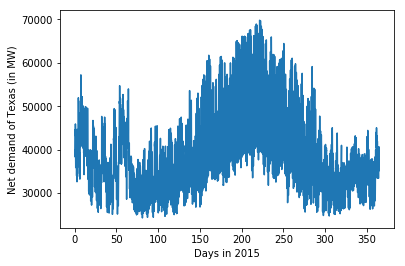

In [3]:
fig = plt.figure()

plt.plot([hour/24 for hour in range(numberOfDays * 24)], demands.values)
plt.xlabel("Days in " + str(year))
plt.ylabel("Net demand of Texas (in MW)")

**Fact.** A significant portion of the demand is usually thermal, i.e., for air conditioners and heating systems.

**Question (5 points).** From the above plot, what can you infer about the climate of Texas? What would you expect if you plotted the same in Illinois? 

**Your answer.** Between the months of May and September, the demand for energy is signicantly higher than the rest of the year, peaking in July. Likewise, there is a small rise around January for energy. This is likely because of the extreemely hot summers in Texas, causing a large demand for air conditioning. Also, the slight rise in energy in January is most likely due heating for the mild winter. If this was a plot of Illinois, I would expect the demand for energy to be significantly higher from November through March with a mild rise from July to August because of our extreeme winters and mediocrely hot summers.


#### Q2. How does day of week affect the load profiles?

The first day in the first plot is Jan 31, 2015.
Day 1 was a Saturday.


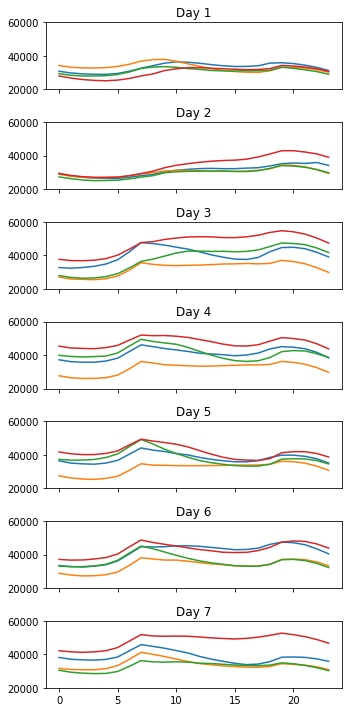

In [4]:
# Plot the load data of the same day of the week over several weeks.

dayStart = 30
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is Jan 31, " + str(year) + ".")
print("Day 1", "was a", DayOfWeek[datetime.date(year, 1, 31).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=60000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

**Question (5 points).** Can you find any discernible change in the load profiles of different days of the week?

**Your answer.** Monday through Friday are very consistant with their peak around the same time (7AM) in the morning and the dropoff towards te night where it makes a small rise. Saturday seems to be consistantly low while Saturday starts low and then has a higher peak at night.

**Question (15 points).** Redo the above exercise for the month of August. Make 'Day 1' correspond to August 15th. What do you observe differently? Do your observations agree with Q1? 

**Your answer (comments here, code below).** Here, every single day of the week is consistant with the work week and varies GREATLY from the observations made in Q1. This is most likely different from Q1 because in a mild winter, you can set a thermostat and after reaching a said tempature it is quite easy to maintain that tempature with minimal energy expenses. Hence the spike in energy use early in the mornings or later on the weekends. During the intense Texan summer though, it cost much more energy to maintain a cool enviroment. We see a peak around 2 or 3 PM which makes sense because mid-day is when the heat is the worst. As the sun lowers and the day comes to an end, the energy demand drops off.

The first day in the first plot is August 15, 2015.
Day 1  was a  Saturday.


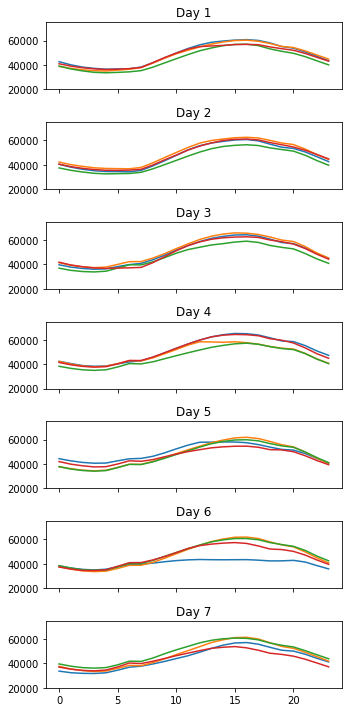

In [5]:
# Modify the following code

# Plot the load data of the same day of the week over several weeks.

dayStart = 226
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is August 15, " + str(year) + ".")
print("Day 1", " was a ", DayOfWeek[datetime.date(year, 8, 15).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=75000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

## Define the demand prediction module.

Use past demand profiles to predict demands a day in advance. We draw two conclusions from the above analysis:
1. Demand profiles have seasonal effects. Therefore, data from the past few days will help in predicting the demands tomorrow.
2. Demand profiles have weekly dependencies. Therefore, data from the same days but a week or two before can be useful in load prediction.

How much past data you want to train over depends on two considerations:
1. Which data in the past is useful in prediction?
2. How complex you want your training process to be? The more features of past data you want to train on, the more complex your neural network should be, and it will require more time to train it.

To strike a balance, use the demand profile from $d-7, d-2, d-1$ to predict the load profile of day $d$.

In [6]:
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]


When you perform regression, it is often desirable to scale the inputs so that it has zero mean and unit variance. Other types of scaling are possible. Here, we cheat a little and scale both the training and test data together. Ideally, they should be scaled separately.

Split the data into two sets: training set and testing set. Train the neural network on the training set, and test how well it performs on the testing set. You should typically never sample from the training set to test your algorithms. The learnt model for prediction should work well on data that the algorithm has never encountered before.

The function 'train_test_split' helps you to split the data into two parts, where 'test_size'
indicates the fraction of the data you want to test on.

In [7]:
X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))


Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


### Design the neural network (NN) for demand prediction with only one hidden layer.

Recall that TensorFlow defines a computation graph where the weights and biases associated with the NN are variables. The goal is to optimize the weights and biases of the NN to minimize prediction error using data. 


To define the computation graph, create the inputs and outputs as 'placeholders'.
The algorithm only expects them to be specified at the time of computation. The
first element of the shape attribute for both inputs and outputs are 'None'. This
means that they are left unspecified, and will be provided at runtime. It will help
in batch training for prediction, where the size of the batch will determine
this value. Batch training is useful because training the NN with one data point at a
time can be time consuming.

In this lab, we begin with a 'relu' activation. We additionally implement 'dropouts' that basically
prevents certain paramters from updating in each round. This is known to prevent overfitting. The number'0.995' in the description below updates 99.5% of all weights, leaving out 0.5%.

Design the optimizer and the loss. For reporting the accuracy of prediction, we choose in this lab the idea of mean absolute error (MAE). For a data set, if the true values are scalars $y_1, \ldots, y_m$ and the predictions are $\hat{y}_1, \ldots, \hat{y}_m$, then its MAE is given by
$$ MAE = \frac{1}{m}\sum|y_i - \hat{y}_i|.$$
If $y$ and $\hat{y}$ are multidimensional, it computes the average across each coordinate of $y$ and $\hat{y}$.

**Question (5 points). Insert a line of code for the output of layer 1 below (use the relu function)** 

In [8]:
# Insert your code where specified
nHidden = 100

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Define the inputs and the target outputs for the NN.
inputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimX])
targetOutputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimY])

# Define the weights, biases, and outputs (Z1 using relu) of the first layer.

# insert code
W1 = tf.Variable(tf.truncated_normal(shape=[nDimX, nHidden]))
b1 = tf.Variable(tf.truncated_normal(shape=[nHidden]))
Z1 = tf.nn.relu(tf.matmul(inputNN, W1) + b1)

outputLayer1 = tf.nn.dropout(Z1, 0.995)

# Define the weights, biases, and outputs (Z2 as a function of outputLayer1 using relu) of the second layer.

# insert code
W2 = tf.Variable(tf.truncated_normal(shape=[nHidden, nDimY]))
b2 = tf.Variable(tf.truncated_normal(shape=[nDimY]))
Z2 = tf.nn.relu(tf.matmul(outputLayer1, W2) + b2)

# Define the output of layer 2.
outputNN = tf.nn.dropout(Z2, 0.995)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

#insert code
loss = tf.losses.mean_squared_error(labels=targetOutputNN, predictions=outputNN)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.4).minimize(loss)

# Compute the MAE metric to judge accuracy of prediction.
_, maeY = tf.metrics.mean_absolute_error(labels=targetOutputNN, predictions=outputNN)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.



### Train the neural network.

Create the training module for the NN. Feed the training data in batches of size 'batchSize'
and ask Tensorflow to run the function 'optimizer'. The number of batches, denoted by 'nBatches'
is then given by the size of your training dataset divided by 'batchSize. Usually, going through
the training data once does not train your NN. You train over the same data multiple
times. More precisely, train it 'nEpochs' times. It is similar to the idea that you never learn
a material by reading through it once!

In [9]:
batchSize = 50
nBatches = int(nTrain/batchSize)
nEpochs = 2000
#used to be nEpochs = 5000

# Define a session.
sess = tf.Session()
with sess.as_default():

    # Initialize the computation graph.
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    print("Started the training module.")

    for epoch in range(nEpochs):

        lossEpoch = 0
        # In each epoch, use 'optimizer' to reduce the 'loss' over batches of data.
        for n in range(nBatches):
            # Define the batch to train on.
            batchX = trainX[n * batchSize: (n + 1) * batchSize]
            batchY = trainY[n * batchSize: (n + 1) * batchSize]

            # Run the optimizer, and specify the placeholders with the inputs and
            # target outputs from the batch.
            
            # insert code
            _, lossBatch = sess.run([optimizer, loss], feed_dict={inputNN: batchX, targetOutputNN: batchY})
            
            # Keep track of the total loss over an entire epoch.
            lossEpoch += lossBatch

        if (epoch + 1) % 200 == 0:
            # Output the loss over an epoch, every few epochs or so.
            print("Epoch: %d - Average loss in last epoch = %1.1f" % (epoch + 1, lossEpoch/nBatches))

    print("Training process completed.")

Started the training module.
Epoch: 200 - Average loss in last epoch = 58290304.8
Epoch: 400 - Average loss in last epoch = 39766456.0
Epoch: 600 - Average loss in last epoch = 27452283.6
Epoch: 800 - Average loss in last epoch = 23300880.0
Epoch: 1000 - Average loss in last epoch = 22562898.0
Epoch: 1200 - Average loss in last epoch = 17171482.4
Epoch: 1400 - Average loss in last epoch = 16776826.4
Epoch: 1600 - Average loss in last epoch = 14886605.2
Epoch: 1800 - Average loss in last epoch = 14323630.8
Epoch: 2000 - Average loss in last epoch = 16727683.2
Training process completed.


### Test the accuracy of prediction via NN.

Here, you report the mean absolute error of your predictions over the 'testX' dataset. Finally, plot the actual demand profile versus the predicted demand profile for a few days from the test data.

In [10]:
    predictedY, maeOfPrediction = sess.run([outputNN, maeY], feed_dict={inputNN: testX, targetOutputNN: testY})
    print("Mean absolute error of forecast = ", maeOfPrediction)

Mean absolute error of forecast =  2781.595


**Question (5 points).** Comment whether your MAE is high or low.

**Hint.** Compare the mean absolute error to the maximum demands.

**Your answer.** (For nEpochs = 5000.) Given that the demand in Texas varies from about 30000-60000MW, the error is relatively low but not phenomenal. With rough guess is that the average demand of 45000MW and absolute error being 2241MW, we can calculate error to be about 5%. It is a good representation, but not perfect.

### Let us visualize the results.


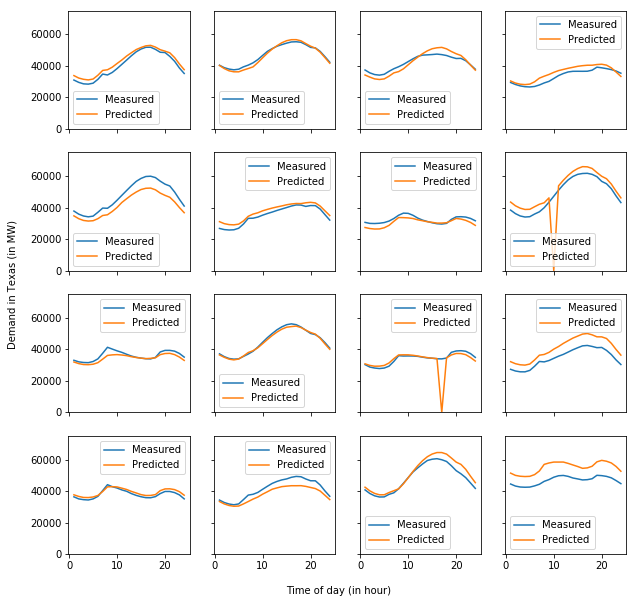

In [11]:
    # Plot the predicted load and compare against the actual load from the test data.
    assert(nTest >= 16)
    days = random.sample(range(nTest), 16)

    fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
    axs = axs.ravel()

    for dd, day in enumerate(days):
        testYDay = testY[day]
        predictedYDay = predictedY[day]

        l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
        l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
        
        axs[dd].set_ylim(bottom=0, top=75000)
        axs[dd].legend()
    
    fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
    fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')
    
    plt.show()

**Question (20 points).** Explore how the number of epochs affects the accuracy and speed of training. Start with 10 epochs, and increase it to 100, 1000, 5000, 10000, and maybe more (do not exceed 20000 unless you have a powerful computer, you are only required to do up to 10000 for this lab). Make comments based on your observations. As an engineer, what is your favorite number of epochs, and why? 

**Your answer.** As the nEpochs increase, the absolute error decreases. As the nEpoch approaches 20000, the absolute error approaches 2000. My favorite is nEpochs = 2000, because it has an error of 2467 which is relatively close to the 2000 Asymptote and any less epochs leads to significantly higher error. Therefor this is the sort of elbow in the Time vs Error curve that I found via testing many numbers.

**Question (20 points).** Fix the number of echos to your favorite one, and then explore how the number of neurons affects the accuracy and speed of training. Start with 6 , and increase it to 12, 24, 48, 100, and more. Make comments based on your observations. As an engineer, what is your favorite number of neurons, and why? 

**Your answer.** I choose 100 nuerons. As the number of nuerons increase, training time and error also increases. At 100, the error seems to have only grown marginally while decreasing the training time (from the original 150). Any further, although lowering training time, significantly increases error.

**Question (30 points).** Fix the number of epochs and neurons to your favorite ones. Then, add another layer to the network. Discuss what your observe in terms of speed and accuracy. If the training becomes too slow, you may alter the number of epochs/neurons. 

**Your answer (comments here, code below). Your code should show the results for the 2 layers case. Go back to the codes above for the 1 layer case and run it again for the same number of epochs/neurons** The speed slowed down marginally when training the 2 layer case but the error significantly increased. It may be because the number of epochs/neurons are chosen as to specifically minimize the error of the 1 layer case but is not enough for the 2 layer case.

In [1]:
# Insert your code where specified
nHidden = 100

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Define the inputs and the target outputs for the NN.
inputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimX])
targetOutputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimY])

# Define the weights, biases, and outputs (Z1 using relu) of the first layer.

# insert code
W1 = tf.Variable(tf.truncated_normal(shape=[nDimX, nHidden]))
b1 = tf.Variable(tf.truncated_normal(shape=[nHidden]))
Z1 = tf.nn.relu(tf.matmul(inputNN, W1) + b1)

outputLayer1 = tf.nn.dropout(Z1, 0.995)

# Define the weights, biases, and outputs (Z2 as a function of outputLayer1 using relu) of the second layer.

# insert code
W2 = tf.Variable(tf.truncated_normal(shape=[nHidden, nHidden]))
b2 = tf.Variable(tf.truncated_normal(shape=[nHidden]))
Z2 = tf.nn.relu(tf.matmul(outputLayer1, W2) + b2)

# Redefine the output of layer 2.
outputLayer2 = tf.nn.dropout(Z2, 0.995)

# Define the weights, biases, and outputs (Z3 as a function of outputLayer2 using relu) of the third layer.

# insert code
W3 = tf.Variable(tf.truncated_normal(shape=[nHidden, nDimY]))
b3 = tf.Variable(tf.truncated_normal(shape=[nDimY]))
Z3 = tf.nn.relu(tf.matmul(outputLayer2, W3) + b3)

# Define the output of layer 2.
outputNN = tf.nn.dropout(Z3, 0.995)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

#insert code
loss = tf.losses.mean_squared_error(labels=targetOutputNN, predictions=outputNN)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.4).minimize(loss)

# Compute the MAE metric to judge accuracy of prediction.
_, maeY = tf.metrics.mean_absolute_error(labels=targetOutputNN, predictions=outputNN)

NameError: name 'np' is not defined

### The effect of wind energy (bonus).

In [12]:
#Let's check the raw data 
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")
dfDemand[:]

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,1/1/15 0:00,1-Jan,39932,871,12730,2.2,6.8,NaN,NaN
1,1/1/15 1:00,1-Jan,39134,724,12730,1.8,5.7,-147.0,-16.9
2,1/1/15 2:00,1-Jan,38560,596,12730,1.5,4.7,-127.0,-17.6
3,1/1/15 3:00,1-Jan,38334,486,12730,1.3,3.8,-110.0,-18.5
4,1/1/15 4:00,1-Jan,38392,651,12730,1.7,5.1,165.0,33.8
5,1/1/15 5:00,1-Jan,38877,745,12730,1.9,5.9,94.0,14.5
6,1/1/15 6:00,1-Jan,39837,788,12730,2.0,6.2,43.0,5.8
7,1/1/15 7:00,1-Jan,40520,758,12730,1.9,6.0,-30.0,-3.8
8,1/1/15 8:00,1-Jan,41008,668,12730,1.6,5.2,-90.0,-11.8
9,1/1/15 9:00,1-Jan,42052,496,12730,1.2,3.9,-172.0,-25.8


Note that in addition to the load data, we have some wind data! 

**Question (20 points).** Subtract the wind data from the load, and redo the above experiment and observe how does wind energy affect the forecasting process. How does the accuracy change? Why? Write down your MAE before and after considering wind energy. 

**Your answer (comments here, code below).** For all that I can tell, the error stays practically the same. This is most likely due to the wind being completely unpredictable and, therefore, past wind data will not allow us to predict future wind data.

In [13]:
_, maeOfPrediction = sess.run([outputNN, maeY], feed_dict={inputNN: testX, targetOutputNN: testY})
print("Mean absolute error of forecast pre-wind = ", maeOfPrediction)

dfDemand.iloc[:, 2] = dfDemand.iloc[:, 2].sub(dfDemand.iloc[:, 3])

daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]
X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))

# Insert your code where specified
nHidden = 100

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Define the inputs and the target outputs for the NN.
inputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimX])
targetOutputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimY])

# Define the weights, biases, and outputs (Z1 using relu) of the first layer.

# insert code
W1 = tf.Variable(tf.truncated_normal(shape=[nDimX, nHidden]))
b1 = tf.Variable(tf.truncated_normal(shape=[nHidden]))
Z1 = tf.nn.relu(tf.matmul(inputNN, W1) + b1)

outputLayer1 = tf.nn.dropout(Z1, 0.995)

# Define the weights, biases, and outputs (Z2 as a function of outputLayer1 using relu) of the second layer.

# insert code
W2 = tf.Variable(tf.truncated_normal(shape=[nHidden, nDimY]))
b2 = tf.Variable(tf.truncated_normal(shape=[nDimY]))
Z2 = tf.nn.relu(tf.matmul(outputLayer1, W2) + b2)

# Define the output of layer 2.
outputNN = tf.nn.dropout(Z2, 0.995)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

#insert code
loss = tf.losses.mean_squared_error(labels=targetOutputNN, predictions=outputNN)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.4).minimize(loss)

# Compute the MAE metric to judge accuracy of prediction.
_, maeY = tf.metrics.mean_absolute_error(labels=targetOutputNN, predictions=outputNN)

batchSize = 50
nBatches = int(nTrain/batchSize)
nEpochs = 2000
#used to be nEpochs = 5000

# Define a session.
sess = tf.Session()
with sess.as_default():

    # Initialize the computation graph.
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    print("Started the training module.")

    for epoch in range(nEpochs):

        lossEpoch = 0
        # In each epoch, use 'optimizer' to reduce the 'loss' over batches of data.
        for n in range(nBatches):
            # Define the batch to train on.
            batchX = trainX[n * batchSize: (n + 1) * batchSize]
            batchY = trainY[n * batchSize: (n + 1) * batchSize]

            # Run the optimizer, and specify the placeholders with the inputs and
            # target outputs from the batch.
            
            # insert code
            _, lossBatch = sess.run([optimizer, loss], feed_dict={inputNN: batchX, targetOutputNN: batchY})
            
            # Keep track of the total loss over an entire epoch.
            lossEpoch += lossBatch

        if (epoch + 1) % 200 == 0:
            # Output the loss over an epoch, every few epochs or so.
            print("Epoch: %d - Average loss in last epoch = %1.1f" % (epoch + 1, lossEpoch/nBatches))

    print("Training process completed.")
    
predictedY, maeOfPrediction = sess.run([outputNN, maeY], feed_dict={inputNN: testX, targetOutputNN: testY})
print("Mean absolute error of forecast post-wind = ", maeOfPrediction)

Mean absolute error of forecast pre-wind =  2951.5122
Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.
Started the training module.
Epoch: 200 - Average loss in last epoch = 50706787.2
Epoch: 400 - Average loss in last epoch = 30499836.4
Epoch: 600 - Average loss in last epoch = 27396801.6
Epoch: 800 - Average loss in last epoch = 20629619.2
Epoch: 1000 - Average loss in last epoch = 18034624.4
Epoch: 1200 - Average loss in last epoch = 16332604.4
Epoch: 1400 - Average loss in last epoch = 17182422.8
Epoch: 1600 - Average loss in last epoch = 13350004.6
Epoch: 1800 - Average loss in last epoch = 14247885.6
Epoch: 2000 - Average loss in last epoch = 16747125.8
Training process completed.
Mean absolute error of forecast post-wind =  3064.6013
